In [7]:
from jorts_utils import *
import pickle

# Loading JKR's partial follower list
DATA_PREFIX = './data'

jkr_followers_time_bounded = json.load(
    open(
        '{}/HASHED_jkr_followers_full_past_20180615.json'.format(DATA_PREFIX), 'rb'
    )
)

# Map each follower user ID to the time at which they followed JKR. 
jkr_followers_ts = {}
for ts, followers_gained in jkr_followers_time_bounded.items():
    for f in followers_gained:
        jkr_followers_ts[f] = ts

In [4]:
import pandas as pd

df_post_2018 = pd.read_csv('{}/jkr_rts_past_20180615.tsv'.format(DATA_PREFIX), sep='\t')
rts_post_2018 = df_post_2018['retweeted_handle'].tolist() # retweeted handles
tss_post_2018 = df_post_2018['created_at'].apply(ts_hyphen_transform) # timestamps of RTs
prefix = '{}/jkr/'.format(DATA_PREFIX)

"""
These data structures map each followed account to a dict with the following structure:
{
    True: {
        ts1: estimated_jkr_followers_gained_on_ts1,
        ts2: estimated_jkr_followers_gained_on_ts2,
        ...
        ts14: estimated_jkr_followers_gained_on_ts14,
    },
    False: {
        ts1: estimated_non_jkr_followers_gained_on_ts1,
        ts2: estimated_non_jkr_followers_gained_on_ts2,
        ...
        ts14: estimated_non_jkr_followers_gained_on_ts14,
    },
}
For followers_gained_post_jkr, ts1 through ts14 are the days of the retweet until 14 days after it.
For followers_gained_pre_jkr, ts1 is 14 days before the retweet up until the day before the retweet.
"""

followers_gained_post_jkr = {} 
followers_gained_pre_jkr = {}
rt_cursors = {} # keeps track of the relevant time bounds with respect to retweets

for rt_acct, rt_ts in zip(rts_post_2018, tss_post_2018):
    amplify_ts_dt = dt.datetime.strptime(rt_ts, '%Y%m%d') # time of amplification
    after_ts_dt = amplify_ts_dt + dt.timedelta(weeks=2) # 2 weeks after; cutoff
    before_ts_dt = amplify_ts_dt - dt.timedelta(weeks=2) # 2 weeks prior; cutoff
    rt_cursors[rt_acct] = (
        dt_to_cursor(amplify_ts_dt), 
        dt_to_cursor(after_ts_dt)
    )
    followers_to_time_bounds = {}

    after_ts = dt.datetime.strftime(after_ts_dt, '%Y%m%d')
    before_ts = dt.datetime.strftime(before_ts_dt, '%Y%m%d')

    follows_on = json.load(
        open(prefix + 'HASHED_{}_following_data_post_{}_all.json'.format(
            rt_acct, rt_ts
        ), 'r'
    )) 

    accumulated_after, followers_to_time_bounds = parse_follower_info_and_begin_interpolation(
        follows_on,
        followers_to_time_bounds,
    )
    follows_before = json.load(
        open(prefix + 'HASHED_{}_following_data_post_{}_all.json'.format(
            rt_acct, before_ts
        ), 'r'
    ))
    
    accumulated_before, followers_to_time_bounds = parse_follower_info_and_begin_interpolation(
        follows_before,
        followers_to_time_bounds,
    )
            
    gained_after_follower, gained_after_non = interpolate_follower_non_follower_accumulation(
        accumulated_after, 
        amplify_ts_dt,
        after_ts_dt,
        followers_to_time_bounds,
        jkr_followers_ts,
        rt_cursors,
        rt_acct,
    )
    followers_gained_post_jkr[rt_acct] = {}
    followers_gained_post_jkr[rt_acct][True] = gained_after_follower
    followers_gained_post_jkr[rt_acct][False] = gained_after_non
    
    gained_before_follower, gained_before_non = interpolate_follower_non_follower_accumulation(
        accumulated_before, 
        before_ts_dt,
        amplify_ts_dt,
        followers_to_time_bounds,
        jkr_followers_ts,
        rt_cursors,
        rt_acct,
    )
    followers_gained_pre_jkr[rt_acct] = {}
    followers_gained_pre_jkr[rt_acct][True] = gained_before_follower
    followers_gained_pre_jkr[rt_acct][False] = gained_before_non

In [8]:
# load in labels for JKR retweeted accounts
dfc = pd.read_csv('{}/jkr_rts_labels_final.tsv'.format(DATA_PREFIX), sep='\t')
print(dfc.columns)

# create a mapping from RT'ed accounts to their coded categories
mappings = {
    'agreement_terf': {},
    'agreement_deleted': {},
    'agreement_ professional poster': {},
    'agreement_non-profes': {},
    'agreement_political entity': {},
    'agreement_interest actor': {},
    'agreement_institution/org': {},
}
for line in dfc.to_dict(orient='records'):
    for k in mappings.keys():
        if line[k] in {'Y', 'N'}:
            mappings[k][line['retweeted_handle']] = line[k]

Index(['Unnamed: 0', 'retweeted_handle', 'agreement_terf', 'agreement_deleted',
       'agreement_ professional poster', 'agreement_non-profes',
       'agreement_political entity', 'agreement_interest actor',
       'agreement_institution/org'],
      dtype='object')


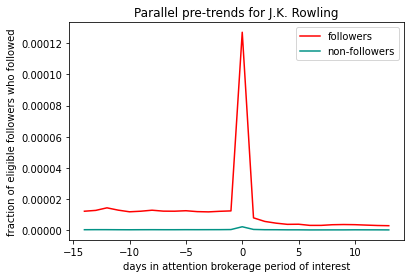

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# pre-trends analysis
lvls_non = {i: [] for i in range(14)}
lvls_foll = {i: [] for i in range(14)}

low_lvl_non = []
high_lvl_non = []
line_non = []
tot_non = 0

low_lvl_foll = []
high_lvl_foll = []
line_foll = []
tot_foll = 0

c = 0

for idx in range(14):
    for rt_acct, v in followers_gained_pre_jkr.items():
        if v == {}:
            lvls_foll[idx] = lvls_foll[idx] + [0]
            lvls_non[idx] = lvls_non[idx] + [0]
            continue
        lvls_foll[idx] = lvls_foll[idx] + [
            sorted([(k, vv) for k, vv in v[True].items()], key=lambda b: b[0])[idx][1] 
        ]
        lvls_non[idx] = lvls_non[idx] + [
            sorted([(k, vv) for k, vv in v[False].items()], key=lambda b: b[0])[idx][1] 
        ]
    mean_non = np.mean([i + c for i in np.array(lvls_non[idx]) / 10e8])
    mean_foll = np.mean([i + c for i in np.array(lvls_foll[idx]) / len(jkr_followers_ts)])

    line_non.append(mean_non)
    
    line_foll.append(mean_foll)
        
low_lvl_non_b4 = low_lvl_non
high_lvl_non_b4 = high_lvl_non

low_lvl_foll_b4 = low_lvl_foll
high_lvl_foll_b4 = high_lvl_foll

line_foll_b4 = line_foll
line_non_b4 = line_non

import numpy as np
lvls_non = {i: [] for i in range(14)}
lvls_foll = {i: [] for i in range(14)}

line_non = []

line_foll = []
for idx in range(14):
    for rt_acct, v in followers_gained_post_jkr.items():
        if v == {}:
            lvls_foll[idx] = lvls_foll[idx] + [0]
            lvls_non[idx] = lvls_non[idx] + [0]
            continue
        lvls_foll[idx] = lvls_foll[idx] + [
            sorted([(k, vv) for k, vv in v[True].items()], key=lambda b: b[0])[idx][1] 
        ]
        lvls_non[idx] = lvls_non[idx] + [
            sorted([(k, vv) for k, vv in v[False].items()], key=lambda b: b[0])[idx][1] 
        ]
    mean_non = np.mean([i + c for i in np.array(lvls_non[idx]) / 10e8])
    mean_foll = np.mean([i + c for i in np.array(lvls_foll[idx]) / len(jkr_followers_ts)])

    line_non.append(mean_non)
    line_foll.append(mean_foll)
        
        
plt.plot(
    [i for i in range(-14, 14)], 
    list(line_foll_b4) + list(line_foll) , 
    color='red', 
    label='followers'
)
plt.plot(
    [i  for i in range(-14, 14)], 
    list(line_non_b4) + list(line_non) , 
    color='xkcd:teal', 
    label='non-followers'
)
plt.xlabel('days in attention brokerage period of interest')
plt.ylabel('fraction of eligible followers who followed')
plt.title('Parallel pre-trends for J.K. Rowling')
plt.legend()

In [24]:
minimum_monday = pd.to_datetime(min([v for v in tss_post_2018]), utc=True)

vecs = []

is_foll = False
# non-followers' gains pre-RT
for acct, gained in followers_gained_pre_jkr.items():
    gained = gained[is_foll]
    if acct not in mappings['agreement_terf']:
        continue
    elif acct not in mappings['agreement_interest actor']:
        continue
    else:
        tup = (
            int(mappings['agreement_terf'][acct] == 'Y'), 
            int(mappings['agreement_interest actor'][acct] == 'Y')
        )
        if tup == (0, 0):
            group = 0
        elif tup == (0, 1):
            group = 1
        elif tup == (1, 0):
            group = 2
        else:
            group = 3
    acct_rt_ts = parse_cursor(rt_cursors[acct][0])
    period = (acct_rt_ts - minimum_monday).days
    acct_type = 0
    for i, k in enumerate(sorted([k for k in gained.keys()])):
        vecs.append({
            'acct': acct, 
            'type': acct_type,
            'gain_rate': gained[k] / 10e8, 
            'period': period, 
            'ts': i - 13,
            'treated': 0,
            'group': int(group)})

# non-followers' gains post-RT
for acct, gained in followers_gained_post_jkr.items():
    gained = gained[is_foll]
    if acct not in mappings['agreement_terf']:
        continue
    elif acct not in mappings['agreement_interest actor']:
        continue
    else:
        tup = (
            int(mappings['agreement_terf'][acct] == 'Y'), 
            int(mappings['agreement_interest actor'][acct] == 'Y')
        )
        if tup == (0, 0):
            group = 0
        elif tup == (0, 1):
            group = 1
        elif tup == (1, 0):
            group = 2
        else:
            group = 3
    acct_rt_ts = parse_cursor(rt_cursors[acct][0])
    period = (acct_rt_ts - minimum_monday).days
    acct_type = 0
    for i, k in enumerate(sorted([k for k in gained.keys()])):
        vecs.append({
            'acct': acct, 
            'type': acct_type,
            'gain_rate': gained[k] / 10e8, 
            'period': period, 
            'ts': i ,
            'treated': 0,
            'group': int(group)})

is_foll = True
# follower gains pre-RT
for acct, gained in followers_gained_pre_jkr.items():
    gained = gained[is_foll]
    if acct not in mappings['agreement_terf']:
        continue
    elif acct not in mappings['agreement_interest actor']:
        continue
    else:
        tup = (
            int(mappings['agreement_terf'][acct] == 'Y'), 
            int(mappings['agreement_interest actor'][acct] == 'Y')
        )
        if tup == (0, 0):
            group = 0
        elif tup == (0, 1):
            group = 1
        elif tup == (1, 0):
            group = 2
        else:
            group = 3
    acct_rt_ts = parse_cursor(rt_cursors[acct][0])
    period = (acct_rt_ts - minimum_monday).days
    acct_type = 0
    if (acct_type, group) not in acct_count_per_group:
        acct_count_per_group[(acct_type, group)] = 1
    else:
        acct_count_per_group[(acct_type, group)] += 1

    tot = 0
    for i, k in enumerate(sorted([k for k in gained.keys()])):
        vecs.append({
            'acct': acct, 
            'type': acct_type,
            'gain_rate': gained[k] / len(jkr_followers_ts), 
            'period': period, 
            'ts': i - 13,
            'treated': 0,
            'group': int(group)})

# follower gains post-RT
for acct, gained in followers_gained_post_jkr.items():
    gained = gained[is_foll]
    if acct not in mappings['agreement_terf']:
        continue
    elif acct not in mappings['agreement_interest actor']:
        continue
    else:
        tup = (
            int(mappings['agreement_terf'][acct] == 'Y'), 
            int(mappings['agreement_interest actor'][acct] == 'Y')
        )
        if tup == (0, 0):
            group = 0
        elif tup == (0, 1):
            group = 1
        elif tup == (1, 0):
            group = 2
        else:
            group = 3
    acct_rt_ts = parse_cursor(rt_cursors[acct][0])
    period = (acct_rt_ts - minimum_monday).days
    acct_type = 0
    for i, k in enumerate(sorted([k for k in gained.keys()])):
        vecs.append({
            'acct': acct, 
            'type': acct_type,
            'gain_rate': gained[k] / len(jkr_followers_ts), 
            'period': period, 
            'ts': i ,
            'treated': 1,
            'group': int(group)})

In [23]:
acct_nums = {}
acct_count = 0
with open('/home/asmithh/all_jkr_did_data_test_all.tsv', 'w') as f:
    f.write('\t'.join(['id', 'X', 'G2', 'G', 'period', 'Y', 'treat', 'ts']))
    f.write('\n')
    for v in vecs:
        to_write = []
        if v['acct'] in acct_nums:
            to_write.append(str(acct_nums[v['acct']]))
        else:
            acct_nums[v['acct']] = acct_count
            acct_count += 1
            to_write.append(str(acct_nums[v['acct']]))
        # to_write.append(','.join([str(1) if k == v['type'] else str(0) for k in jorts_acct_types.keys()  ]))
        to_write.append(','.join(['0' for i in range(8)]))
        to_write.append(str(v['type']))
        to_write.append(str(v['group']))
        to_write.append(str(v['period']))
        to_write.append(str(v['gain_rate']))
        to_write.append(str(v['treated']))
        to_write.append(str(v['ts']))
        f.write('\t'.join(to_write) + '\n')